In [10]:
from skimage.measure import block_reduce
import numpy as np

import logging

from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt

from notebook_utils import plot 
import config

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [11]:
from utils import data_provider

In [ ]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped'),
    'mnist-3-digits': data_provider.MNIST3DigitsData(dir_path='../data/mnist'),
    'mnist-3-digits-maj': data_provider.MNIST3DigitsWithMajorityData(dir_path='../data/mnist'),
    'fashion-mnist-3-items': data_provider.MNIST3DigitsData(dir_path='../data/fashion-mnist'),
}

# Define functions

In [ ]:
def get_data_for_class(data_name, class_idx, no=16, seed=2):
    np.random.seed(seed)

    data = dataset[data_name]
    indices = np.argmax(data.test2d.y, axis=1) == class_idx
    if no:
        s = np.random.choice(np.sum(indices), size=no, replace=False)
        return data.test2d.x[indices,:,:][s, :, :]
    else:
        return data.test2d.x[indices,:,:]

In [ ]:
mnist_8 = get_data_for_class('mnist-3-digits', 8)
mnist_8_maj = get_data_for_class('mnist-3-digits-maj', 8)
fmnist_ankle_boots = get_data_for_class('fashion-mnist-3-items', 9)

In [ ]:
def plot_digits(data, title=""):
    plt.figure(figsize=(16,1))
    for i in range(data.shape[0]):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:])
        plt.xticks([])
        plt.yticks([])
    if title:
        plt.suptitle(title)
    plt.show()

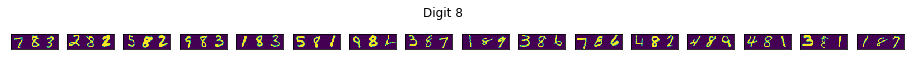

In [8]:
plot_digits(mnist_8, 'Digit 8')

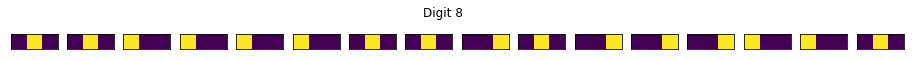

In [9]:
plot_digits(mnist_8_maj, 'Digit 8')

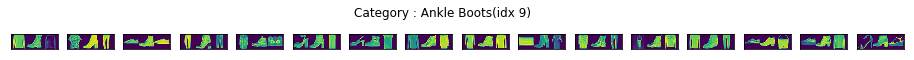

In [8]:
plot_digits(fmnist_ankle_boots, 'Category : Ankle Boots(idx 9)')

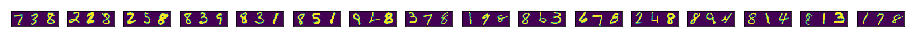

In [9]:
def swap_items(x, seed=7):
    np.random.seed(seed)
    new_x = np.zeros(x.shape)
    for i in range(x.shape[0]):
        indices = [0,1,2]
        while indices[1] == 1:
            np.random.shuffle(indices)
        for j in range(3):
            idx = indices[j]
            new_x[i, :, j*28:(j+1)*28] = x[i, :, idx*28:(idx+1)*28]
    return new_x

mnist_8_swapped = swap_items(mnist_8, seed=0)
plot_digits(mnist_8_swapped)

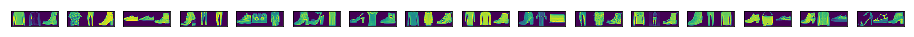

In [10]:
fmnist_ankle_boots_swapped = swap_items(fmnist_ankle_boots, seed=0)
plot_digits(fmnist_ankle_boots_swapped)

In [11]:
data = {
    'mnist-3-digits': (mnist_8, 8),
    'fashion-mnist-3-items': (fmnist_ankle_boots, 9)
}

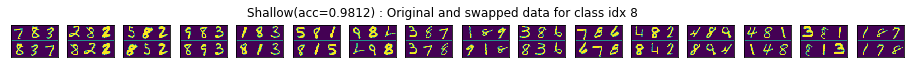

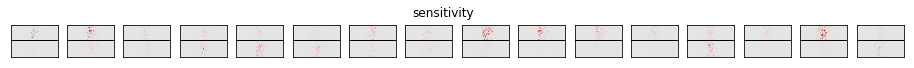

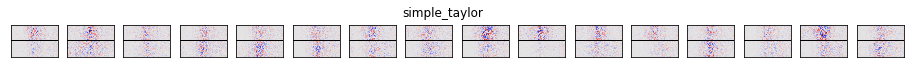

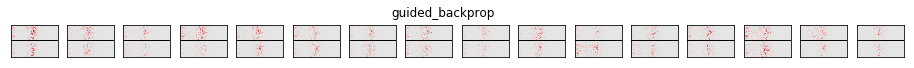

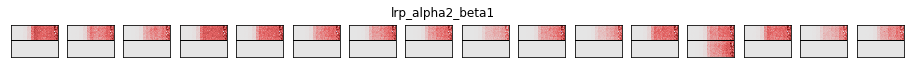

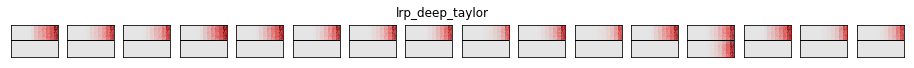

In [12]:
def plot_explain_for_class(model_path):
    methods=['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_deep_taylor']

    model_obj = provider.load(model_path)
    (x, class_idx) = data[model_obj._.dataset]

    gap = 2
    def concat_data(x1, x2, gap=5):
        new_x = np.zeros((x1.shape[0], x1.shape[1]*2+gap, x1.shape[2]))
        new_x[:, 0:28, : ] = x1
        new_x[:, -28:, : ] = x2
        return new_x
    
    x_swapped = swap_items(x)
    
    plot_digits(concat_data(x, x_swapped, gap=gap), title="%s(acc=%.4f) : Original and swapped data for class idx %d"
                % ( config.MODEL_NICKNAMES[model_obj._.architecture_name.replace('_network', '')], model_obj._.accuracy, class_idx)
               )
    
    d_dict = dict(original=x, swapped=x_swapped)

    y = np.zeros((x.shape[0], 10))
    y[:, class_idx] = 1

    for m in methods:
        _, heatmaps = getattr(model_obj, 'rel_%s' % m)(x, y)
        _, heatmaps_swapped = getattr(model_obj, 'rel_%s' % m)(x_swapped, y)
        
        heatmaps = plot.norm_and_make_rgb_heatmap(heatmaps)
        heatmaps_swapped = plot.norm_and_make_rgb_heatmap(heatmaps_swapped)
        
        new_x = np.zeros((x.shape[0], x.shape[1]*2+gap, x.shape[2], 3))
        new_x[:, 0:28, :, : ] = heatmaps
        new_x[:, -28:, :, : ] = heatmaps_swapped
        
        concated_heatmaps = new_x
        plot_digits(concated_heatmaps, title='%s' % (m))
        
plot_explain_for_class('../experiment-results/3-items-dataset/aws-training/s2_network-mnist-3-digits-seq-12---2018-02-07--11-14-03')

# Results of random sequence experiment

## Shallow architecture

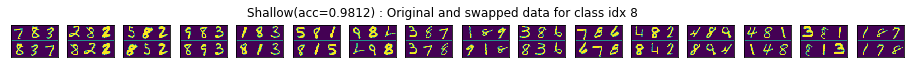

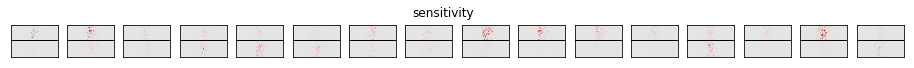

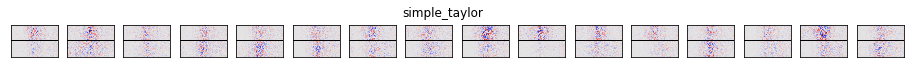

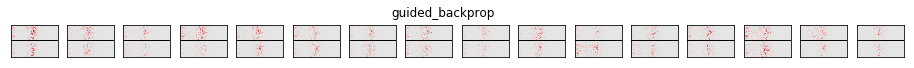

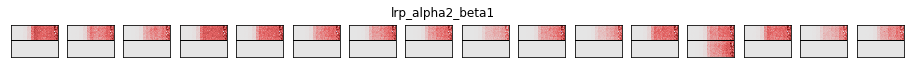

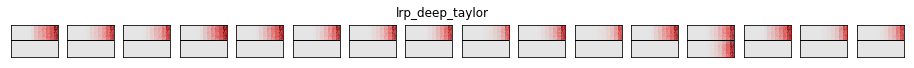

In [13]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/s2_network-mnist-3-digits-seq-12---2018-02-07--11-14-03")

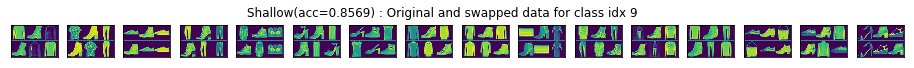

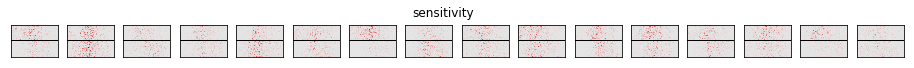

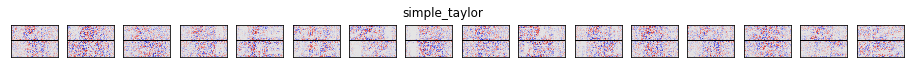

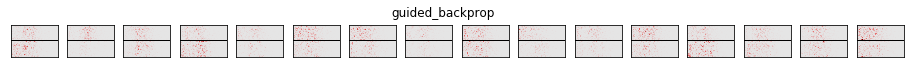

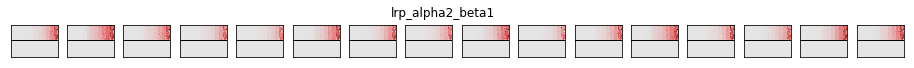

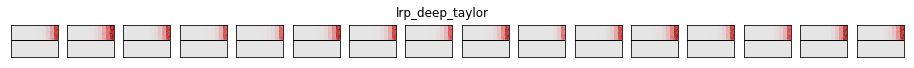

In [14]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/s2_network-fashion-mnist-3-items-seq-12---2018-02-07--23-33-47")

## Deep architecture

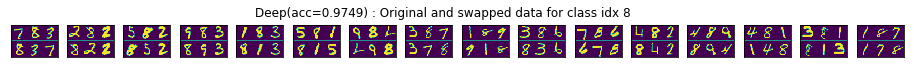

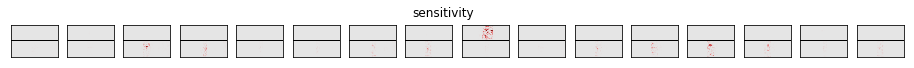

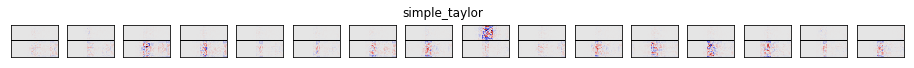

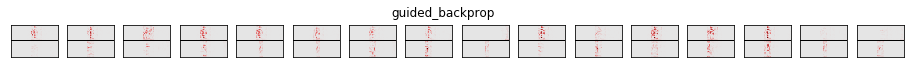

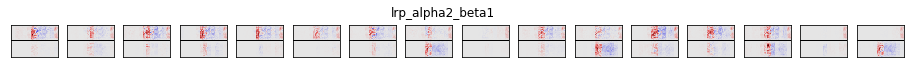

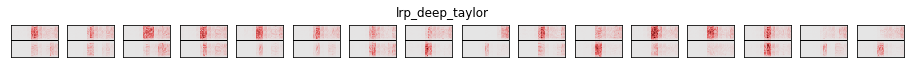

In [15]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/s3_network-mnist-3-digits-seq-12---2018-02-07--16-02-30") 

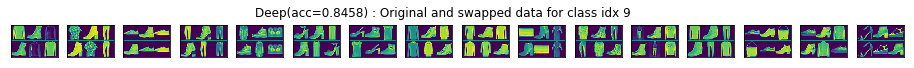

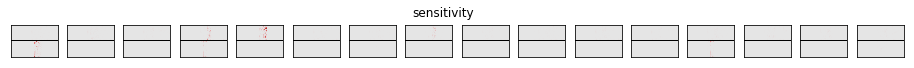

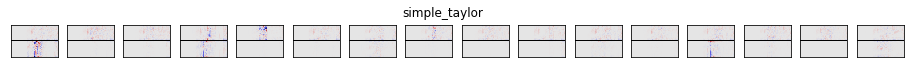

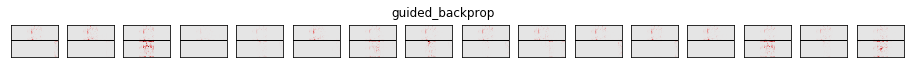

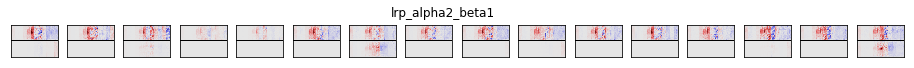

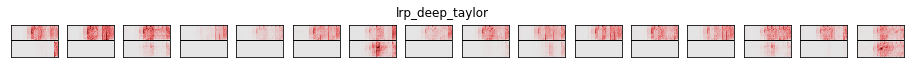

In [16]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/s3_network-fashion-mnist-3-items-seq-12---2018-02-07--23-40-05")

## DeepV2 architecture

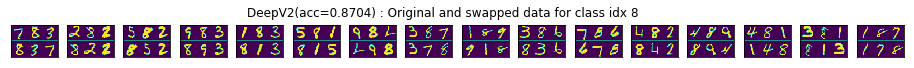

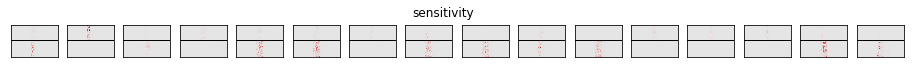

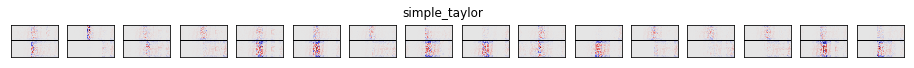

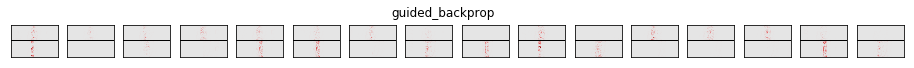

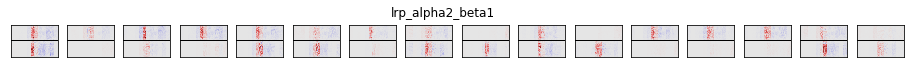

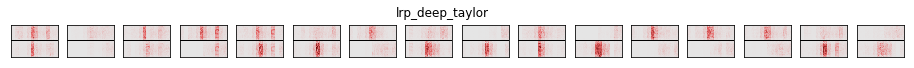

In [17]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/deep_4l_network-mnist-3-digits-seq-12---2018-02-07--10-36-12")

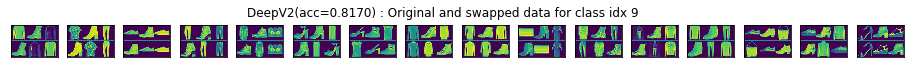

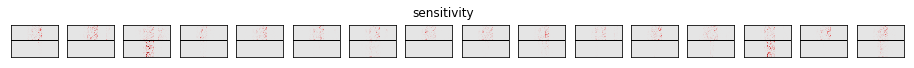

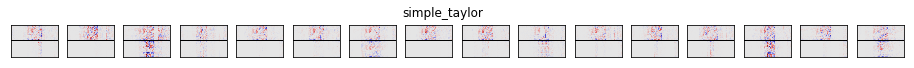

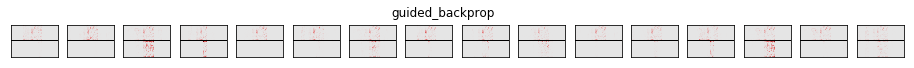

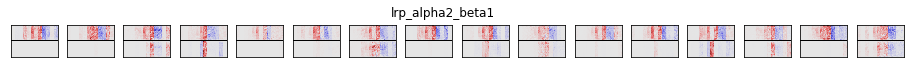

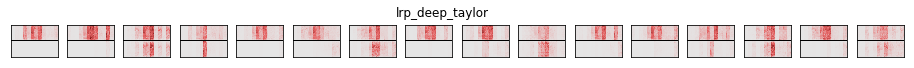

In [18]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/deep_4l_network-fashion-mnist-3-items-seq-12---2018-02-08--08-47-11")

## ConvDeep architecture

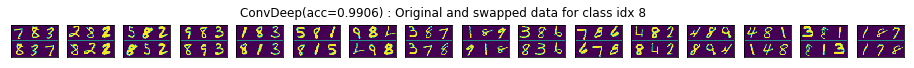

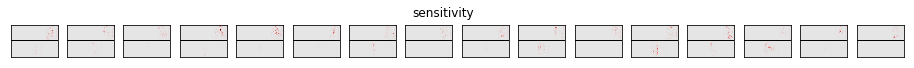

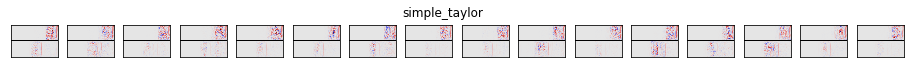

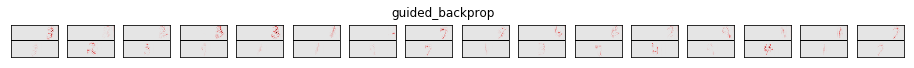

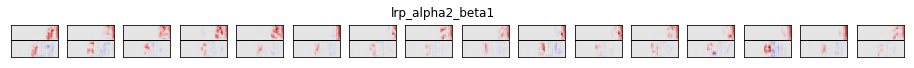

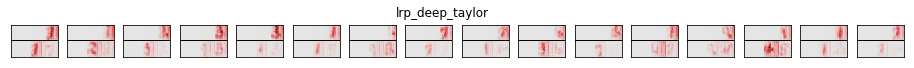

In [19]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/convdeep_4l_network-mnist-3-digits-seq-12---2018-02-07--12-05-37")

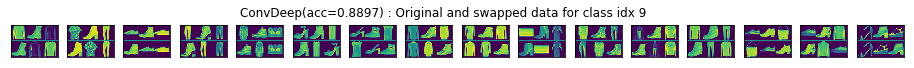

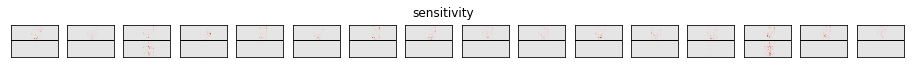

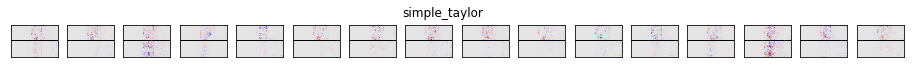

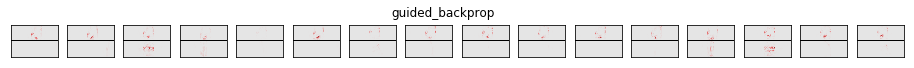

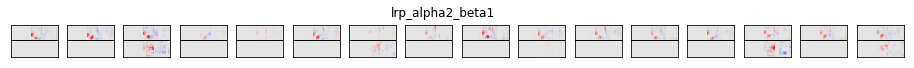

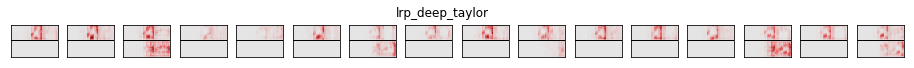

In [20]:
plot_explain_for_class("../experiment-results/3-items-dataset/aws-training/convdeep_4l_network-fashion-mnist-3-items-seq-12---2018-02-07--23-35-50")

# Results of translating objects

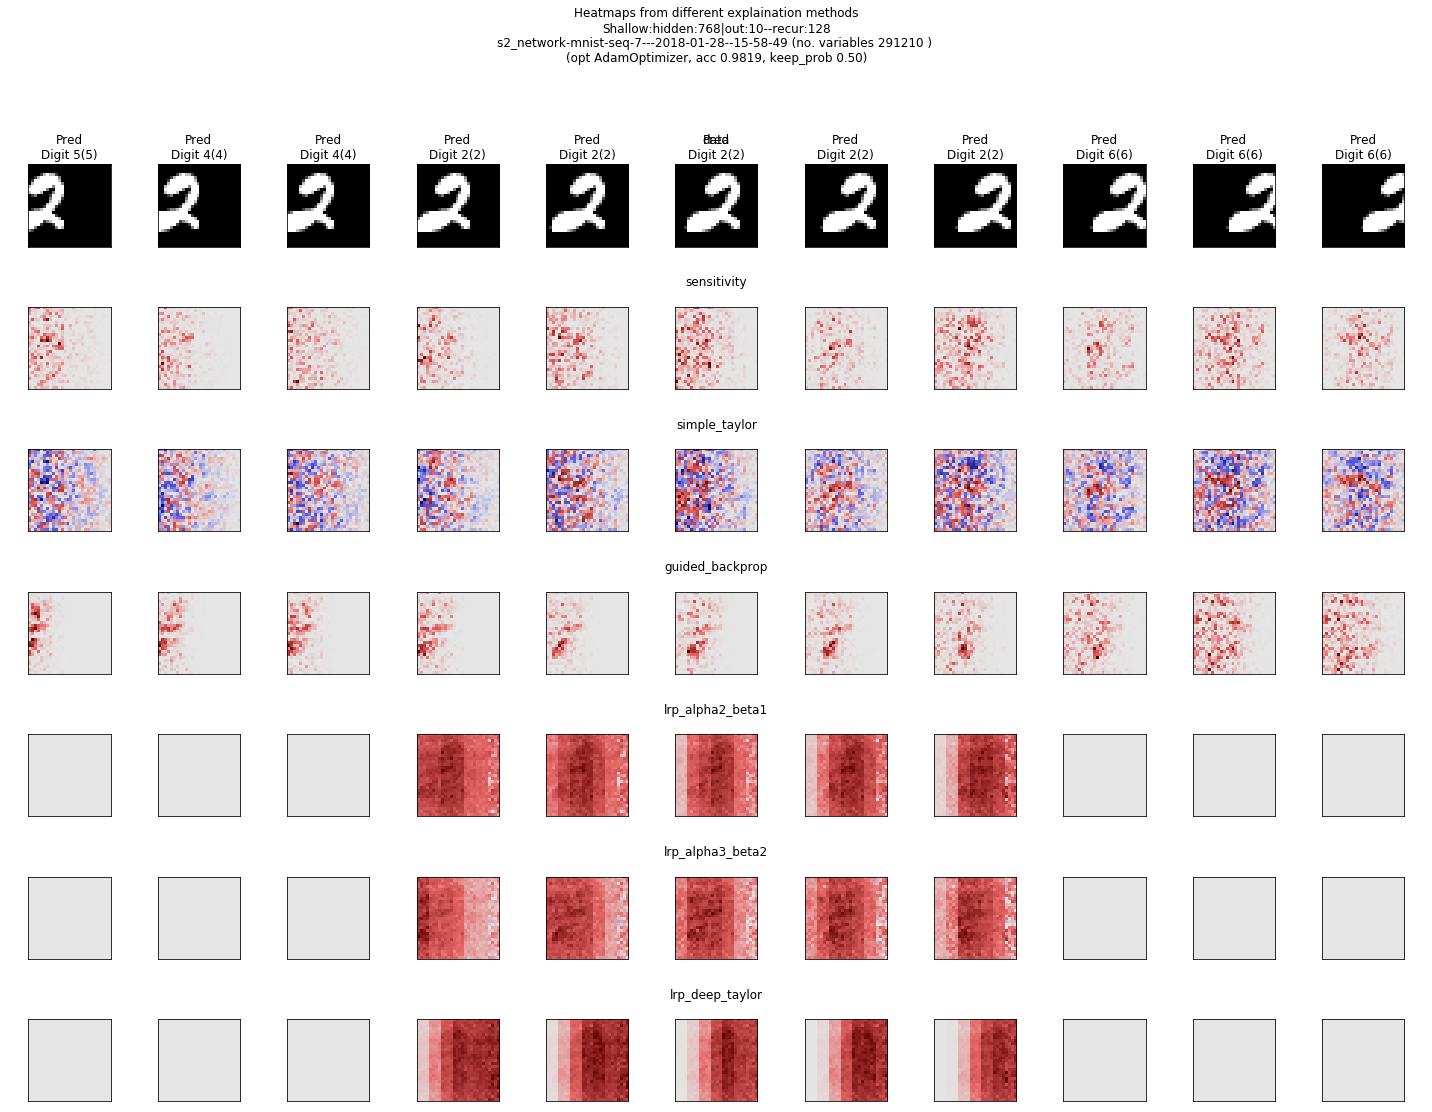

In [86]:
data_idx=6949

def explain_translation_objects(architecture, dataset_name, seq, data_idx):
    model_path = '.%s' % provider._model_path(architecture, dataset_name, seq)
    xi = dataset[dataset_name].test2d.x[data_idx, :, :]
    yi = dataset[dataset_name].test2d.y[data_idx, :]
    
    x = -np.ones((11, xi.shape[0], xi.shape[1]))
    y = np.tile(yi, (11,1))
    translation = (np.arange(0, 11) - 5)*2
    for i in range(11):
        dx = translation[i]

        if dx < 0:
            sp = 28+dx
            x[i, :, :sp] = xi[:, -dx:]
        elif dx > 0:
            x[i, :, dx:] = xi[:, :-dx]
        else:
            x[i, :, :] = xi

    plot.plot_relevance_methods(model_path, dataset[dataset_name], data=(x,y)) 

explain_translation_objects('s2', 'mnist', 7, data_idx)

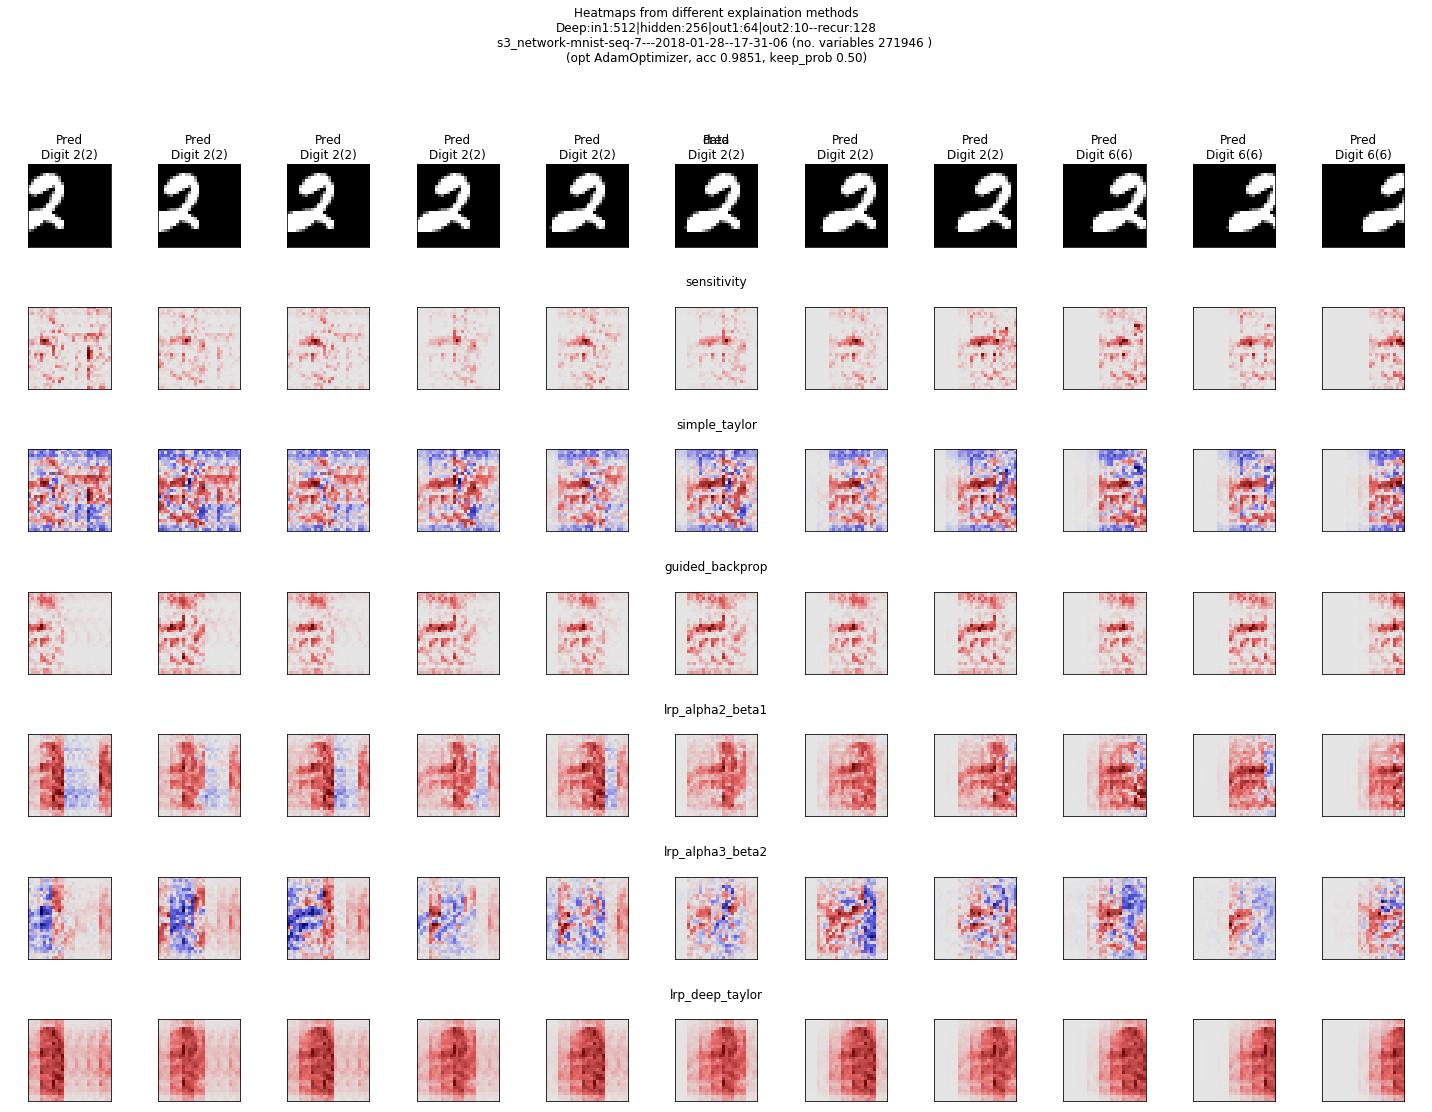

In [87]:
explain_translation_objects('s3', 'mnist', 7, data_idx)

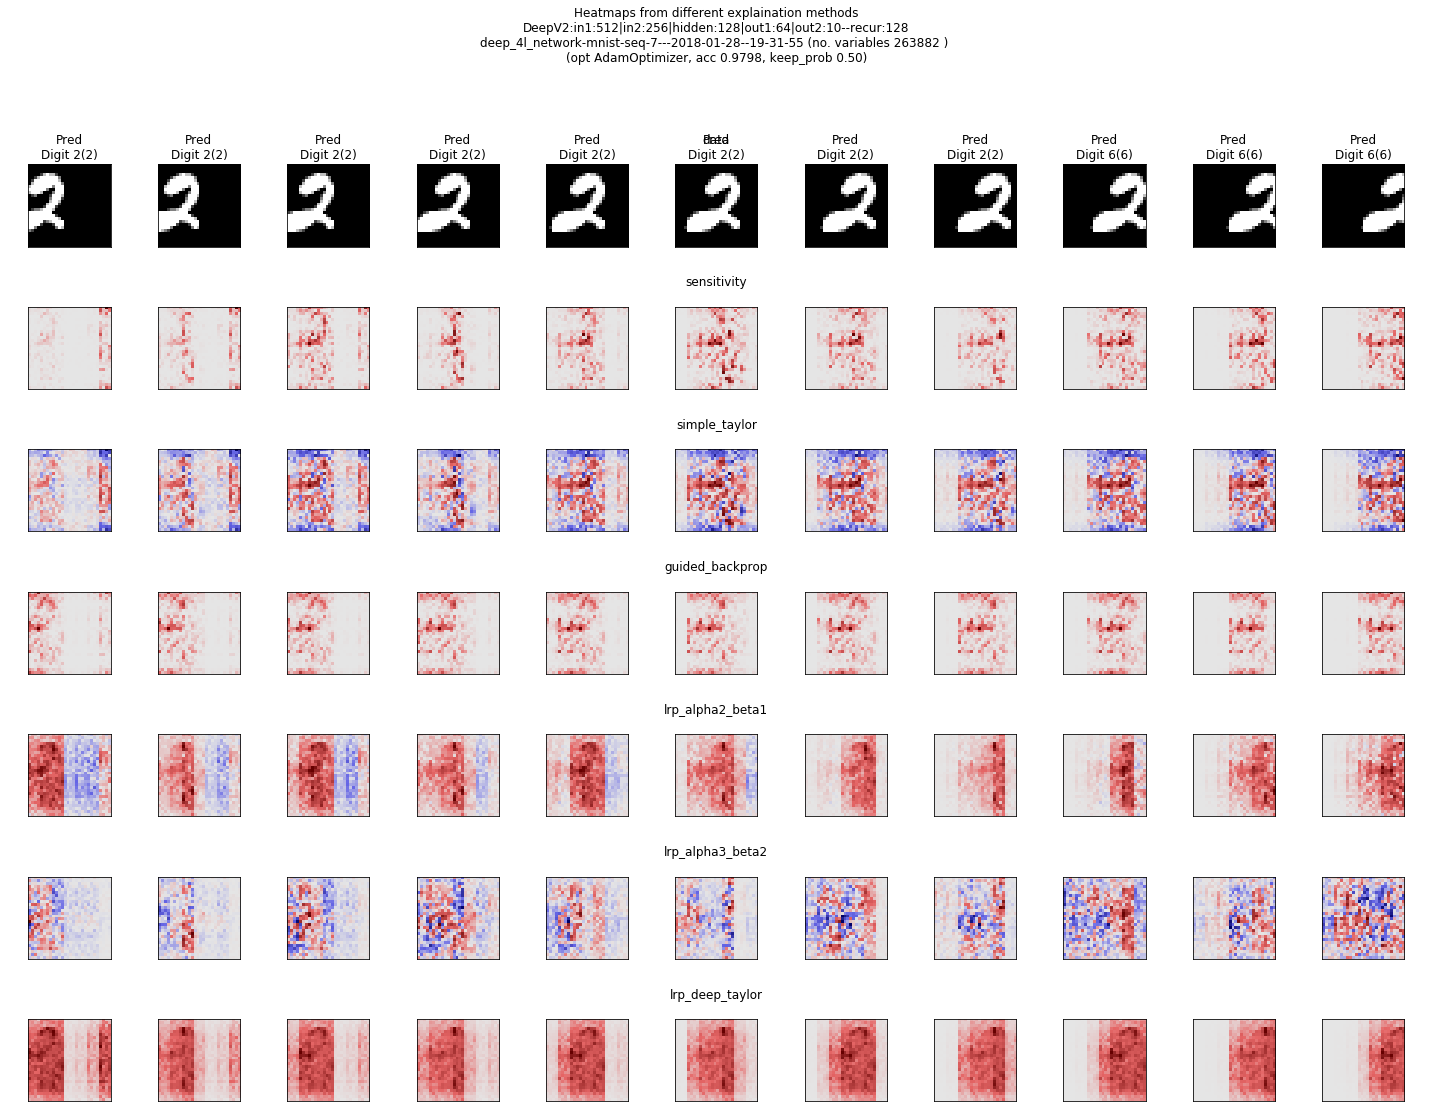

In [88]:
explain_translation_objects('deep_4l', 'mnist', 7, data_idx)

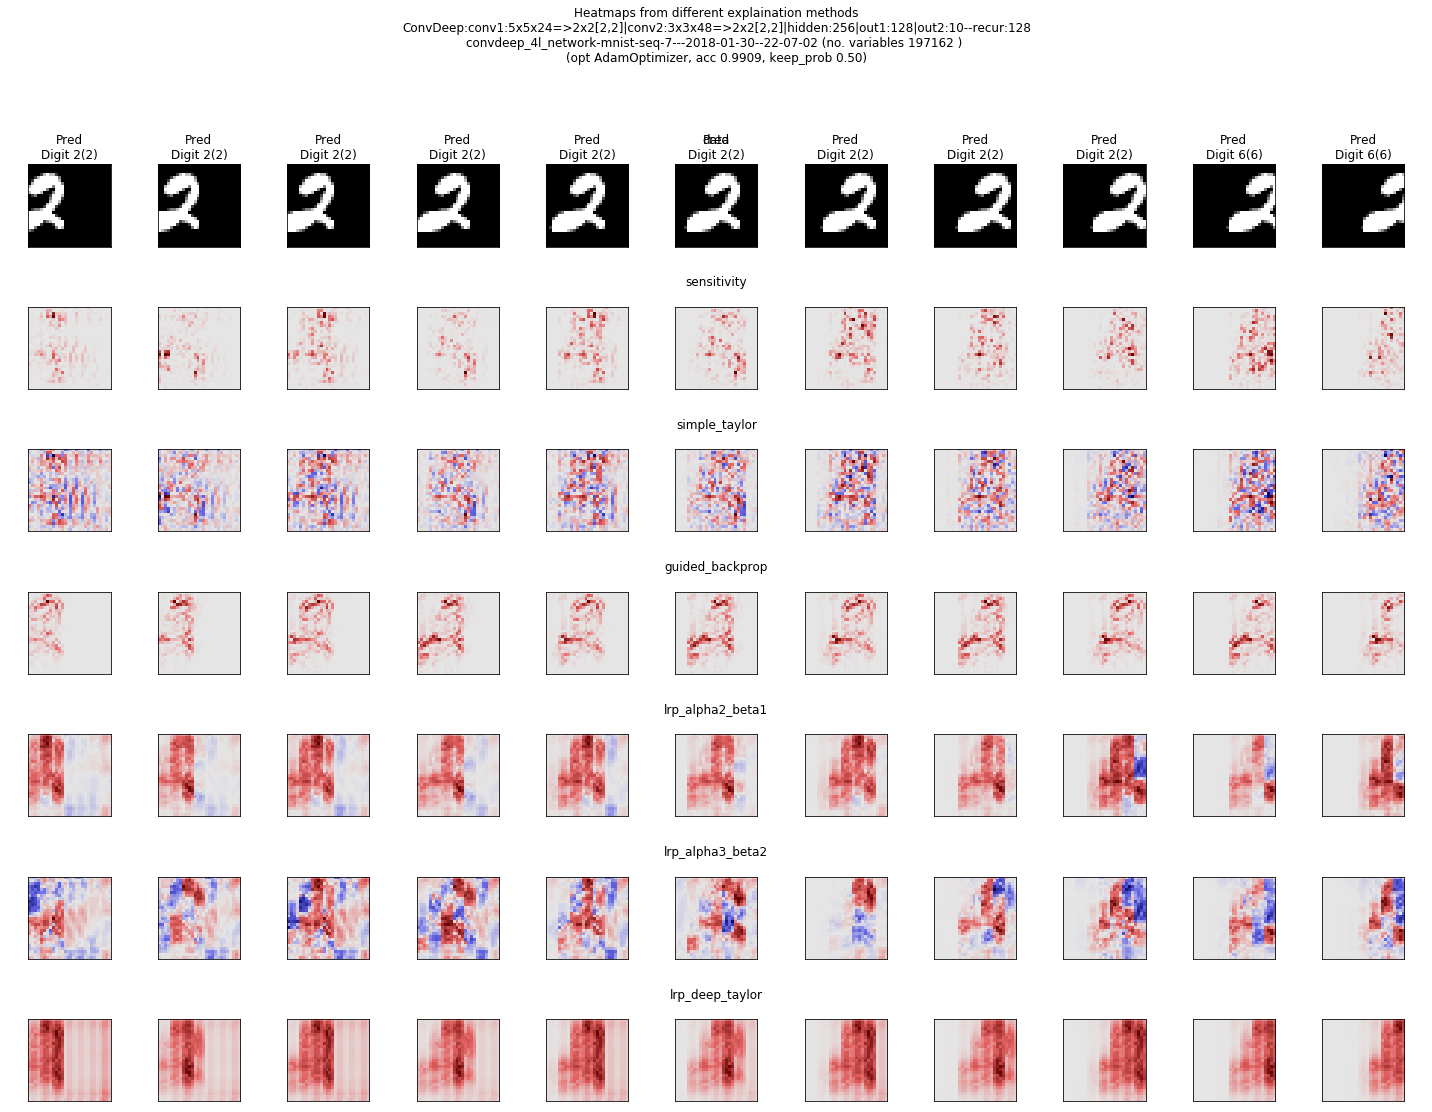

In [91]:
explain_translation_objects('convdeep_4l', 'mnist', 7, data_idx)

In [89]:
# explain_translation_objects('convdeep_4l', 'mnist', 4, data_idx)

In [90]:
# explain_translation_objects('convdeep_4l', 'mnist', 1, data_idx)